# Tomography data segmentation of solidifying Cobalt 

### Scientific Background

Cobalt-alloys are promising candidates to replace Nickel as the material of choice for gas turbine blades. An increase in service temperature and hence efficiency of gas turbines is expected by various research groups. As these blades are usually manufactured by casting, it is critical to know how the material solidifies under various conditions, and how these affect the material properties.
We designed an experiment during which small specimens of a Cobalt-alloy were melted and cooled. X-ray tomography was performed during cooling, generating a 3D-image every 12 seconds. This allows us to track the crystal growth and microstructure formation during

### Why Machine Learning?

The dataset contains almost 800 tomograms, amounting to around 12 Terabytes of 3D image data. Crystals in the images need to be segmented from other phases in the images, such as liquid, oxides, air, background and artifacts.
For conventional image processing, a pipeline of loading, conversion, filtering, segmentation, labeling and saving is set up, which is then applied to every tomogram. This procedure can be scripted and automated, but takes around 6.5 minutes per tomogram on a double Xeon + Quattro workstation. About 60 GB of memory are required and the whole procedure requires 84 hours running time.
Furthermore, this pipeline has to be adjusted for different experimental conditions, which vary significantly.
Using convolutional neural networks, the processing time can be reduced to 2 minutes per tomogram and 26 hours in total on the same system, without requiring lots of memory or its full computing power.

### Data format and preparation

Five tomograms representative for different experimental conditions were conventionally segmented to generate a ground truth dataset, in form of five corresponding binary 3D masks.

Conveniently, tomogram slices are always quadratic in shape.

Data format of tomograms: 32b float Tiff and 16b unsigned Tiff slices, 512 x 512 pixel

<img src="https://raw.githubusercontent.com/Tiwi68/Co_segmentation/main/s0004_frame_00074_694x692x2150_32b_R0384.jpg" width="256" height="256">

Data format of binaries: 8b Tiff slices, 512 x 512 pixel

<img src="https://raw.githubusercontent.com/Tiwi68/Co_segmentation/main/s0004_frame_00074_694x692x2150_R_8b_bin0384.jpg" width="256" height="256">

### Set up

Import dependencies:

In [53]:
import os

import numpy as np
import pandas as pd
from scipy import ndimage
import random
from skimage import transform
from skimage import exposure
from PIL import Image
from datetime import datetime
from keras import Input
from keras import Model
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from tensorflow import image as im
import matplotlib.pyplot as plt

Define image and mask paths, image size to shrink to:

In [4]:
K.clear_session()

imagefolder = 'C:/Users/Tim/Desktop/imseg/images/'
maskfolder = 'C:/Users/Tim/Desktop/imseg/mask/'

image_size = 512 #keeping original size

Load image and mask file names into a dataframe and shuffle, in order to preserve the allocation of images and binary masks:

In [5]:
fileindex = pd.DataFrame({'imagename' : os.listdir(imagefolder),
                          'maskname' : os.listdir(maskfolder)})
fileindex_shuf = fileindex.sample(frac=1, random_state=5)

### Generator with image augmentation

This generator feeds batches of augmented image+mask pairs to the model. The inputs are the filename index, a range of filename-indices to be selected, and the batch size. The generator ADDS augmented images to the batch, resulting in an output batch size which is 4x the input batch size.

In [6]:
def generator(data, min_index, max_index, batch_size):
    # check if a certain range of filenames is defined, otherwise select first and last.
    if max_index == None:
        max_index = fileindex_shuf.shape[0] - 1
    if min_index == None:
        min_index = 0
    i = min_index
    
    while True:
        #  select batch of filenames
        if i + batch_size > max_index:
            i = min_index # prevent running out of data by looping back to the first index.
        batch_files = data[i : i + batch_size]
        
        # create empty batches with batch_files length, as this can
        # be shorter than the defined batch size when exceeding the max_index.
        # Types are set to 32b float for images and binary for masks.
        imagebatch = np.zeros((batch_files.shape[0]*4, image_size, image_size, 1), dtype='float32')
        maskbatch = np.zeros((batch_files.shape[0]*4, image_size, image_size, 1), dtype='bool')
        
        #Augmentation loop
        for j in range(0, batch_files.shape[0]):
            #load image file j into array and resize if required
            image = Image.open(imagefolder + batch_files.iloc[j]['imagename'])
            imagec = np.asarray(image.resize((image_size, image_size),
                                             Image.NEAREST)).astype('float32')
            
            # apply median filter to de-noise images. Not required if they are downsized.
            imagec = ndimage.median_filter(imagec, 2)
            
            #standardise greyscale values and expand dimensions by 1
            imagec = (imagec - np.mean(imagec))/np.std(imagec)
            imagec = np.expand_dims(imagec, 2)
            
            #load mask file j into array and expand dimensions
            mask = Image.open(maskfolder + batch_files.iloc[j]['maskname'])
            maskc = np.asarray(mask)
            maskc = np.expand_dims(maskc, 2)
            
            #resize if required without interpolation, round slight deviations to 0 and 1
            maskc = np.around(im.resize(maskc, [image_size, image_size],
                                  method='mitchellcubic'), decimals=0)
            maskc = maskc.astype('bool')
            
            # Original and augmented image+mask pairs are added to output batch
            
            #original image
            imagebatch[j * 4 + 0] = imagec
            maskbatch[j * 4 + 0] = maskc
            
            #randomly transform or flip
            randflip = random.randint(0, 4)
            if randflip == 0:
                #flip LR
                imagebatch[j * 4 + 1] = np.fliplr(imagec)
                maskbatch[j * 4 + 1] = np.fliplr(maskc)
            elif randflip == 1:
                #flip UD
                imagebatch[j * 4 + 1] = np.flipud(imagec)
                maskbatch[j * 4 + 1] = np.flipud(maskc)
            elif randflip == 2:
                #rotate
                randangle = random.randint(10, 360)
                imagebatch[j * 4 + 1] = transform.rotate(imagec, randangle)
                maskbatch[j * 4 + 1] = transform.rotate(maskc, randangle)
            elif randflip == 3:
                #shift
                randtransx = random.randint(1, image_size)
                randtransy = random.randint(1, image_size)
                transf1 = transform.AffineTransform(
                    translation=(randtransx, randtransy))
                imagebatch[j * 4 + 1] = transform.warp(imagec, transf1, mode='wrap')
                maskbatch[j * 4 + 1] = transform.warp(maskc, transf1, mode='wrap')
            else:
                #shear
                randshear = random.uniform(-0.5, 0.5)
                transf2 = transform.AffineTransform(shear=randshear)
                imagebatch[j * 4 + 1] = transform.warp(imagec, transf2, mode='wrap')
                maskbatch[j * 4 + 1] = transform.warp(maskc, transf2, mode='wrap')
            
            #blur and sometimes flip
            randblur = random.randint(0, 2)
            if randblur == 0:
                imagebatch[j * 4 + 2] = np.flipud(
                    ndimage.uniform_filter(imagec, size=3))
                maskbatch[j * 4 + 2] = np.flipud(maskc)
            elif randblur == 1:
                imagebatch[j * 4 + 2] = np.fliplr(
                    ndimage.uniform_filter(imagec, size=3))
                maskbatch[j * 4 + 2] = np.fliplr(maskc)
            else:
                imagebatch[j * 4 + 2] = ndimage.uniform_filter(imagec, size=3)
                maskbatch[j * 4 + 2] = maskc
            
            #log colour correction and sometimes flip
            randlog = random.randint(0, 2)
            if randlog == 0:
                newimg = imagec + np.abs(np.min(imagec))
                newimg = exposure.adjust_log(newimg)
                imagebatch[j * 4 + 3] = np.flipud(
                    newimg - np.abs(np.min(imagec)))
                maskbatch[j * 4 + 3] = np.flipud(maskc)
            elif randlog == 1:
                newimg = imagec + np.abs(np.min(imagec))
                newimg = exposure.adjust_log(newimg)
                imagebatch[j * 4 + 3] = np.fliplr(
                    newimg - np.abs(np.min(imagec)))
                maskbatch[j * 4 + 3] = np.fliplr(maskc)
            else:
                newimg = imagec + np.abs(np.min(imagec))
                newimg = exposure.adjust_log(newimg)
                imagebatch[j * 4 + 3] = newimg - np.abs(np.min(imagec))
                maskbatch[j * 4 + 3] = maskc
        
        i += batch_size
        yield imagebatch, maskbatch


### Model

Custom Dice loss and metric are used:

In [7]:
def dice_coef(y_true, y_pred, smooth=0.000001):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred) # binary crossentropy outputs are float between 0 and 1
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


Hyperparameters for the model and generators are defined. Around 10000 images are available, of which 6000 are selected for training, 2000 for validation and the rest for testing.

In [8]:
batch_size = 2 #actually 4x bigger due to augmentation

# define training, validation, test generators
train_gen = generator(fileindex_shuf, min_index=0, max_index=6000,
                      batch_size=batch_size)
val_gen = generator(fileindex_shuf,
                    min_index=6000, max_index=8000, batch_size=batch_size)
test_gen = generator(fileindex_shuf,
                     min_index=8000, max_index=None, batch_size=5)

# steps per epoch
train_steps = 6000 // batch_size
val_steps = (8000 - 6000) // batch_size
test_steps = (fileindex_shuf.shape[0] - 8000) // batch_size


Building the model using CNNs in a U-Net architecture. The Keras functional API is used, as it is flexible, permits to use loops for more compact code and to carry residual information between distant layers. 5 levels of contraction and expansion are stacked and the weights of each contraction level added back to the respective expansion level. Padding is applied to maintain constant layer sizes.

In [9]:
# define model input with (img height, img width, img channels), 1 channel for greyscale
inputs = Input(shape=(image_size, image_size, 1))
x = inputs

# provide filter and kernel size for each loop
filters_list = [8, 16, 32, 64, 128]#, 256]#, 512]#, 1024]
kernel_list = [3, 3, 3, 3, 3]
residual = []

# contraction loop
for filters, kernels in zip(filters_list, kernel_list):
    x = layers.Conv2D(filters, kernels, padding='same')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernels, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    
    residual.append(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

# expansion loop
for k, filters, kernels in zip(range(0, len(filters_list))[::-1],
                               filters_list[::-1], kernel_list[::-1]):
    x = layers.Conv2DTranspose(filters, kernels, padding='same')(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2DTranspose(filters, kernels, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D(2)(x)
    x = layers.concatenate([x, residual[k]])

# Output layer with per-pixel binary classification
outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

# instantiate model
model = Model(inputs, outputs)

The model was run multiple times with different learning rates, and 0.01 is a good match.

Stochastic Gradient Descent converges within 5 epochs.

A checkpoint is defined to save the model weights after every epoch, if the dice coefficient is better than after the previous epoch.

In [13]:
learning_rate = 0.01
epochs = 5

#define optimiser and compile model for binary segmentation
opt = optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy',
              metrics=([dice_coef]))

#checkpoint saving model after every epoch
model_checkpoint = callbacks.ModelCheckpoint(
    filepath='C:/Users/Tim/Desktop/MLpython/tmp/tmp_Co_SGD_lr0.01_8-128_Conv_BC_ep{epoch:02d}-vl{val_loss:.4f}_L.h5',
    save_weights_only=True,
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True)

Train the model, save the final result and gather the training metrics in a dictionary:

In [14]:
history = model.fit(train_gen, steps_per_epoch=train_steps, epochs=epochs,
                    validation_data=val_gen, validation_steps=val_steps,
                    shuffle=False, verbose=2)#, callbacks=[model_checkpoint])

model.save('best_model.h5')

metrics_dict = {'learning rate': learning_rate,
                'train_loss': history.history['loss'],
                'val_loss': history.history['val_loss'],
                'train_dice': history.history['dice_coef'],
                'val_dice': history.history['val_dice_coef']}

Epoch 1/5
3000/3000 - 954s - loss: 0.0540 - dice_coef: 0.9788 - val_loss: 0.0508 - val_dice_coef: 0.9795
Epoch 2/5
3000/3000 - 1002s - loss: 0.0507 - dice_coef: 0.9798 - val_loss: 0.0492 - val_dice_coef: 0.9800
Epoch 3/5
3000/3000 - 1001s - loss: 0.0487 - dice_coef: 0.9804 - val_loss: 0.0467 - val_dice_coef: 0.9810
Epoch 4/5
3000/3000 - 957s - loss: 0.0473 - dice_coef: 0.9809 - val_loss: 0.0469 - val_dice_coef: 0.9807
Epoch 5/5
3000/3000 - 900s - loss: 0.0462 - dice_coef: 0.9812 - val_loss: 0.0442 - val_dice_coef: 0.9819


This takes around 70 minutes on my GTX 1060.

Plot the training history:

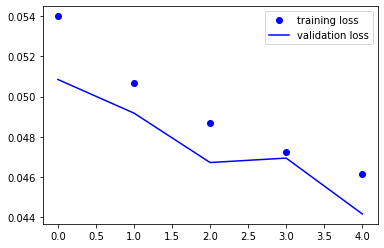

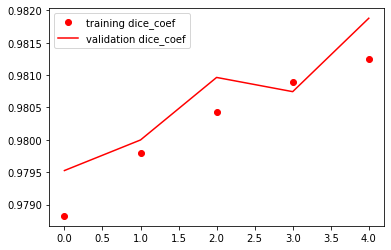

In [16]:
plt.plot(range(len(history.history['loss'])), history.history['loss'],
         'bo', label='training loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'],
         'b', label='validation loss')
plt.legend()
plt.figure()
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'],
         'ro', label='training dice_coef')
plt.plot(range(len(history.history['dice_coef'])), history.history['val_dice_coef'],
         'r', label='validation dice_coef')
plt.legend()

More epochs would improve the results further

### Test image

Predict a test image (not using the previously defined test set generator):

In [18]:
testbatch = np.zeros((1,image_size, image_size,1), dtype='float32')

testimage = Image.open(imagefolder + fileindex_shuf.iloc[9050]['imagename'])
testimagec = np.asarray(testimage.resize(
    (image_size, image_size), Image.NEAREST))
testimagec = (testimagec - np.mean(testimagec))/np.std(testimagec)
testimagec = np.expand_dims(testimagec, 2)
testbatch[0] = testimagec

testmask = Image.open(maskfolder + fileindex_shuf.iloc[9050]['maskname'])
testmaskc = np.asarray(testmask.resize((image_size, image_size)))
testmaskc = np.expand_dims(testmaskc, 2)
#resize without interpolation, round slight deviations
testmaskc = np.around(im.resize(testmaskc, [image_size, image_size],
                                method='mitchellcubic'), decimals=0)
testmaskc = testmaskc.astype('bool')

test_predict = model.predict(testbatch)

Plot the test image:

s0107_frame_00023_582_598_2150_16b_r1203.tif
min 1.0643967e-08 max 0.99668616


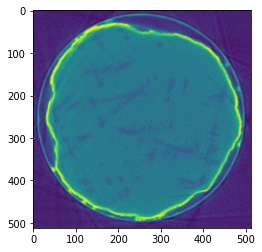

In [44]:
pred_img = test_predict[0, :, :, 0]
print(fileindex_shuf.iloc[9050]['imagename'])
print('min', np.min(pred_img), 'max', np.max(pred_img))
plt.imshow(testimagec[:,:,0])

Plot the true mask:

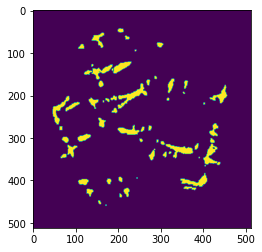

In [38]:
plt.imshow(testmaskc[:,:,0])

Plot the predicted mask:

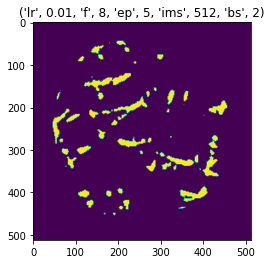

In [46]:
pred_img = np.greater(pred_img, 0.4) # a threshold of 0.4 gives good results.
plt.imshow(pred_img)
plt.title(('lr', learning_rate, 'f', filters_list[0], 'ep', epochs,
          'ims', image_size, 'bs', batch_size))
plt.show()

The prediction looks excellent.

### Predicting a tomogram

Since I now have saved a model delivering satisfactory results, I can use it to predict an entire tomogram of 2000 image slices.

Analogous to above, I need test image folders and a dataframe with the test image filenames.

In [47]:
K.clear_session()

imagefolder = 'C:/Users/Tim/Desktop//imseg/test_images/'
outputfolder = 'C:/Users/Tim/Desktop//imseg/Output/'

image_size = 512

#make dataframe with list of image filenames and shuffle
fileindex = pd.DataFrame({'imagename' : os.listdir(imagefolder)})

Set a timestamp to measure prediction time and load the model.

Predict results for all images in the folder and save them using a loop (could probably be done with a generator instead.)

In [66]:
timestamp = datetime.now()
print(timestamp)
print('loading model...')

dependencies = {'dice_coef': dice_coef}

model = models.load_model('best_model.h5', custom_objects=dependencies)

print(datetime.now())

print('predicting...')
for k in range(64, len(fileindex)): # images below file 64 are missing in this case
    # load image, resize, standardise and give 1 extra dimension for greyscale
    testimage = Image.open(imagefolder + fileindex.iloc[k]['imagename'])
    testimagec = np.asarray(testimage.resize(
        (image_size, image_size), Image.NEAREST))
    testimagec = (testimagec - np.mean(testimagec))/np.std(testimagec)
    testimagec = np.expand_dims(testimagec, 2)
    testimagec = np.expand_dims(testimagec, 0)
    
    # prediction
    #print('predicting', fileindex.iloc[k]['imagename']) # print all slice names if needed
    test_predict = model.predict(testimagec)
    
    # apply a threshold as the output are probabilities between 0 and 1. Save as Tiff.
    round_img = np.greater(test_predict, 0.5) # a threshold of 0.4 produces appropriate results
    predim = Image.fromarray(round_img[0,:,:,0])
    savepath = outputfolder + 'Pred_' + fileindex.iloc[k]['imagename']
    predim.save(savepath, compression=None)

print('start time', timestamp)
print('end time', datetime.now())

2021-01-22 16:14:41.976091
loading model...
2021-01-22 16:14:42.555972
predicting...
start time 2021-01-22 16:14:41.976091
end time 2021-01-22 16:16:34.438921


It takes slightly more than 2 minutes on my machine.

The predicted image is on the left, the conventionally segmented one on the right. A good match is achieved, although the neural network appears to produce slightly checkered surfaces. This does not matter significantly for quantification.

<img src="https://raw.githubusercontent.com/Tiwi68/Co_segmentation/main/s0017_f0098_NN_Av.jpg" width="500" height="500">